# Importing required libraries and defining some constants

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from collections import OrderedDict
from functools import partial
from random import shuffle
import matplotlib.pyplot as plt
import os
import re

C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
image_size = 224
input_shape = (1, image_size, image_size, 3)

vgg_mean = [123.68, 116.779, 103.939]

alpha = 1e3
beta = 1e-3

In [3]:
def load_weights(weights_file, end_layer):

    layers = OrderedDict()
    weights = np.load(weights_file)
    sorted_weights = sorted(weights.items())

    for i, (k, w) in enumerate(sorted_weights):
        # If we have loaded the correct number of layers we stop
        # to save memory
        if sum([1 if len(v)==2 else 0 for v in layers.values()]) >= end_layer:
            break
        
        if k[:-2] not in layers:
            layers[k[:-2]] = {}
            
        if re.search(r'conv\d+_\d+_W', k) is not None:
            layers[k[:-2]]['weights'] = w
            print()
        if re.search(r'conv\d+_\d+_b', k) is not None:
            layers[k[:-2]]['bias'] = w
  
        print('Loading the weights for the layer {} and shape {}'.format(k,w.shape))

    return layers

assert_msg = 'You need to download the vgg16_weights.npz'+\
                ' file by visiting https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz'+\
                ' and place that in a folder called vgg in your project directory'
assert os.path.exists(os.path.join('vgg','vgg16_weights.npz')), assert_msg

vgg_layers = load_weights(os.path.join('vgg','vgg16_weights.npz'),7)


Loading the weights for the layer conv1_1_W and shape (3, 3, 3, 64)
Loading the weights for the layer conv1_1_b and shape (64,)

Loading the weights for the layer conv1_2_W and shape (3, 3, 64, 64)
Loading the weights for the layer conv1_2_b and shape (64,)

Loading the weights for the layer conv2_1_W and shape (3, 3, 64, 128)
Loading the weights for the layer conv2_1_b and shape (128,)

Loading the weights for the layer conv2_2_W and shape (3, 3, 128, 128)
Loading the weights for the layer conv2_2_b and shape (128,)

Loading the weights for the layer conv3_1_W and shape (3, 3, 128, 256)
Loading the weights for the layer conv3_1_b and shape (256,)

Loading the weights for the layer conv3_2_W and shape (3, 3, 256, 256)
Loading the weights for the layer conv3_2_b and shape (256,)

Loading the weights for the layer conv3_3_W and shape (3, 3, 256, 256)
Loading the weights for the layer conv3_3_b and shape (256,)


In [4]:
def define_inputs(input_shape):

    
    content = tf.placeholder(name='content', shape=input_shape, dtype=tf.float32)
    style = tf.placeholder(name='style', shape=input_shape, dtype=tf.float32)
    generated = tf.get_variable(name='generated', initializer=tf.random_normal_initializer(), 
                                shape=input_shape, dtype=tf.float32, trainable=True)
    
    return {'content': content, 'style': style, 'generated': generated}


def define_tf_weights():

    
    for k, w_dict in vgg_layers.items():
        w, b = w_dict['weights'], w_dict['bias']
        with tf.variable_scope(k):
            tf.get_variable(name='weights', initializer=tf.constant(w, dtype=tf.float32), trainable=False)
            tf.get_variable(name='bias', initializer=tf.constant(b, dtype=tf.float32), trainable=False)


In [5]:
def get_vgg_pooling_indices(sorted_layer_ids):

    pool_inds = []
    prev_layer_id = int(sorted_layer_ids[0][4])
    for ki, k in enumerate(sorted_layer_ids):
        layer_id = int(k[4])
        if layer_id != prev_layer_id:
            pool_inds.append(ki-1)
        prev_layer_id = layer_id
    return pool_inds

pool_inds = get_vgg_pooling_indices(list(vgg_layers.keys()))
print('pooling indices are: {}'.format(pool_inds))

pooling indices are: [1, 3]


In [6]:
def build_vggnet(inp, layer_ids, pool_inds, on_cpu=False):
    outputs = OrderedDict()
    
    out = inp

    for lid in layer_ids:
        with tf.variable_scope(lid, reuse=tf.AUTO_REUSE):
            print('Computing outputs for the layer {}'.format(lid))
            w, b = tf.get_variable('weights'), tf.get_variable('bias')
            out = tf.nn.conv2d(filter=w, input=out, strides=[1,1,1,1], padding='SAME')
            out = tf.nn.relu(tf.nn.bias_add(value=out, bias=b))
            outputs[lid] = out

        if lid in pool_inds:
            with tf.name_scope(lid.replace('conv','pool')):
                out = tf.nn.avg_pool(input=out, ksize=[1,2,2,1], strides=[1, 2, 2, 1], padding='SAME')
                outputs[lid.replace('conv','pool')] = out

    return outputs

In [7]:

def define_content_loss(inputs, layer_ids, pool_inds, c_weight):

    c_outputs = build_vggnet(inputs["content"], layer_ids, pool_inds)
    g_outputs = build_vggnet(inputs["generated"], layer_ids, pool_inds)

    content_loss = c_weight * tf.reduce_mean(0.5*(list(c_outputs.values())[-1] - list(g_outputs.values())[-1])**2)
    
    return content_loss

In [8]:
def define_style_matrix(layer_out):

    n_channels = layer_out.get_shape().as_list()[-1]
    unwrapped_out = tf.reshape(layer_out, [-1, n_channels])
    style_matrix = tf.matmul(unwrapped_out, unwrapped_out, transpose_a=True)
    return style_matrix

def define_style_loss(inputs, layer_ids, pool_inds, s_weight, layer_weights=None):

    c_outputs = build_vggnet(inputs["style"], layer_ids, pool_inds)
    g_outputs = build_vggnet(inputs["generated"], layer_ids, pool_inds)
    
    c_grams = [define_style_matrix(v) for v in list(c_outputs.values())]
    g_grams = [define_style_matrix(v) for v in list(g_outputs.values())]
    
    if layer_weights is None:
        style_loss =  s_weight * \
            tf.reduce_sum([(1.0/len(layer_ids)) * tf.reduce_mean((c - g)**2) for c,g in zip(c_grams, g_grams)])
    else:
        style_loss = s_weight * \
            tf.reduce_sum([tf.gather(layer_weights, i) * 0.5 * \
                            tf.reduce_mean((c - g)**2) for i,(c,g) in enumerate(zip(c_grams, g_grams))])
    
    return style_loss

## Defining the optimizer

Next you use the Adam optimizer to optimize the loss of the network.

In [9]:
def define_optimize(loss, learning_rate = 5.0):
    
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
    opt_op = opt.minimize(loss)
    return opt_op

# The tf.data input pipeline

Here you will be defining an input pipeline, to read a set of given images, do a bit of preprocessing and define an iterator which will produce these preprocessed images one by one.

## Let's see an image
Let us visualize an image and see if they are okey.

(-0.5, 755.5, 598.5, -0.5)

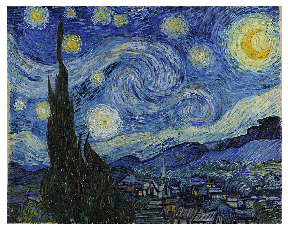

In [10]:
plt.imshow(Image.open(os.path.join('data','style_1.jpg')))
plt.axis('off')

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession(
    config=tf.ConfigProto(allow_soft_placement=True)
)

def image_gen_func(data_dir, file_match_str, do_shuffle=True):

    files = [f for f in os.listdir(data_dir) if f.startswith(file_match_str)]
    if do_shuffle:
        shuffle(files)
    
    mean = np.array([[vgg_mean]])
    
    for f in files:
        img = Image.open(os.path.join(data_dir, f))
        
        width, height = img.size
        
        if width < height:
            left,right = 0, width
            top, bottom = (height-width)/2, ((height-width)/2) + width
        elif width > height:
            top, bottom = 0, height
            left, right = (width - height)/2, ((width-height)/2) + height
        else:
            arr = np.array(img.resize((image_size,image_size))).astype(np.float32)
            yield (arr, mean)
        
        arr = np.array(img.crop((left, top, right, bottom)).resize((image_size,image_size))).astype(np.float32)
        yield (arr, mean)
    

def load_images_iterator(gen_func, zero_mean=False):

    image_dataset = tf.data.Dataset.from_generator(
        gen_func, 
        output_types=(tf.float32, tf.float32), 
        output_shapes=(tf.TensorShape(input_shape[1:]), tf.TensorShape([1, 1, 3]))
    )
    
    if zero_mean:
        image_dataset = image_dataset.map(lambda x,y: (x - y, y))
    
    image_dataset = image_dataset.batch(1)
    iterator = image_dataset.make_one_shot_iterator()
    return iterator

part_style_gen_func = partial(image_gen_func, 'data', "style_")
part_content_gen_func = partial(image_gen_func, 'data', "content_")

style_iter = load_images_iterator(part_style_gen_func, zero_mean=False)
content_iter = load_images_iterator(part_content_gen_func, zero_mean=False)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


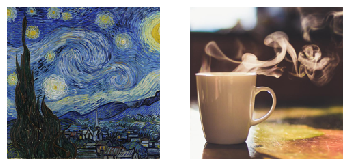

In [12]:
next_style_image = style_iter.get_next()
next_content_image = content_iter.get_next()

plt.subplot(1,2,1)
plt.imshow(sess.run(next_style_image)[0][0]/255.0)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sess.run(next_content_image)[0][0]/255.0)
plt.axis('off')

sess.close()

In [13]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config)

part_style_gen_func = partial(image_gen_func, 'data', "style_")
part_content_gen_func = partial(image_gen_func, 'data', "content_")

style_iter = load_images_iterator(part_style_gen_func, zero_mean=True)
content_iter = load_images_iterator(part_content_gen_func, zero_mean=True)

inputs = define_inputs(input_shape)
define_tf_weights()

layer_ids = list(vgg_layers.keys())

gen_ph = tf.placeholder(shape=input_shape, dtype=tf.float32)
init_generated = tf.assign(inputs["generated"], gen_ph)

c_loss = define_content_loss(
    inputs=inputs, 
    layer_ids=layer_ids, pool_inds=pool_inds, c_weight=alpha
)

layer_weights_ph = tf.placeholder(shape=[len(layer_ids)], dtype=tf.float32, name='layer_weights')
s_loss = define_style_loss(
    inputs=inputs, 
    layer_ids=layer_ids, pool_inds=pool_inds, s_weight=beta, layer_weights=None
)

tot_loss = c_loss + s_loss

optimize = define_optimize(tot_loss)

Computing outputs for the layer conv1_1
Computing outputs for the layer conv1_2
Computing outputs for the layer conv2_1
Computing outputs for the layer conv2_2
Computing outputs for the layer conv3_1
Computing outputs for the layer conv3_2
Computing outputs for the layer conv3_3
Computing outputs for the layer conv1_1
Computing outputs for the layer conv1_2
Computing outputs for the layer conv2_1
Computing outputs for the layer conv2_2
Computing outputs for the layer conv3_1
Computing outputs for the layer conv3_2
Computing outputs for the layer conv3_3
Computing outputs for the layer conv1_1
Computing outputs for the layer conv1_2
Computing outputs for the layer conv2_1
Computing outputs for the layer conv2_2
Computing outputs for the layer conv3_1
Computing outputs for the layer conv3_2
Computing outputs for the layer conv3_3
Computing outputs for the layer conv1_1
Computing outputs for the layer conv1_2
Computing outputs for the layer conv2_1
Computing outputs for the layer conv2_2


In [14]:
def save_image_with_restore(image, img_mean, save_path):
    
    image_restored = image + img_mean
    image_restored = np.clip(image_restored,0,255.0)
    image_restored = image_restored.astype('uint8')
    Image.fromarray(image_restored).save(save_path)
    
    
def get_layer_weights(type_id, num_layers):

    
    if type_id == 0:
        weights = np.arange(1,num_layers+1)**1.5
        weights = weights/np.sum(weights)
    if type_id == 1:
        weights = np.arange(1,num_layers+1)**1.5
        weights = weights/np.sum(weights)
        weights = weights[::-1]
        
    return weights

In [15]:
del vgg_layers 

n_iter = 500 
num_images = 1

for j in range(num_images):
    print('\nProcessing the {}th image ...'.format(j+1))
    tf.global_variables_initializer().run()
    (cont, cont_mean), (style, style_mean) = sess.run([content_iter.get_next(), style_iter.get_next()])
    
    if not os.path.exists(os.path.join('data','gen_{}'.format(j))):
        os.mkdir(os.path.join('data', 'gen_{}'.format(j)))
    save_image_with_restore(cont[0], cont_mean[0], os.path.join('data', 'gen_{}'.format(j),'content.jpg'))
    save_image_with_restore(style[0], style_mean[0], os.path.join('data', 'gen_{}'.format(j),'style.jpg'))
    
    sess.run(init_generated, feed_dict={gen_ph:cont})
    for i in range(n_iter):

        l, _ = sess.run([tot_loss,optimize], feed_dict={
            inputs["content"]: cont,
            inputs["style"]: style,
            layer_weights_ph: get_layer_weights(0, len(layer_ids))
        })

        if (i+1)%500==0:
            print('\tLoss at iteration {}: {}'.format(i+1, l))
            gen_image = sess.run(inputs["generated"])
            save_image_with_restore(gen_image[0], cont_mean[0], os.path.join('data', 'gen_{}'.format(j),'gen_{}.jpg'.format(i+1)))



Processing the 1th image ...
	Loss at iteration 500: 850504056832.0

Processing the 2th image ...


OutOfRangeError: End of sequence
	 [[node IteratorGetNext_3 (defined at <ipython-input-15-4ac50ad5a8cd>:9) ]]

Errors may have originated from an input operation.
Input Source operations connected to node IteratorGetNext_3:
 OneShotIterator (defined at <ipython-input-11-e9a288dd579c>:57)

Original stack trace for 'IteratorGetNext_3':
  File "C:\Users\sindr\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\sindr\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\sindr\Anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\sindr\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\sindr\Anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\Users\sindr\Anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\Users\sindr\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 377, in dispatch_queue
    yield self.process_one()
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\gen.py", line 714, in __init__
    self.run()
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\sindr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-4ac50ad5a8cd>", line 9, in <module>
    (cont, cont_mean), (style, style_mean) = sess.run([content_iter.get_next(), style_iter.get_next()])
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 426, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1947, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Users\sindr\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()
